In [1]:
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

!pip install networkx ply cirq

import sys
sys.meta_path[:] = [f for f in sys.meta_path if "DaskFinder" not in str(f)]

import cirq
import networkx as nx
import random as rand
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
import numpy.random as npr

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


to build genome, we're looking to make a function that can convert a function with a defined mutation function $\mu$ that maps from a type genome to genome, should i create a class? nah bad idea no reason to deal with that lmao. then we use a fitness function $\nu$

lol i made a class

$\mu: G \mapsto G$: what am i supposed to d here lma
uhhhh, make a

In [2]:
# hyper parameters

MUT_CHANCE = 0.2
EXPLORE = 0.2 # chance to add new gate

GATES = ["H", "Rx", "Ry", "Rz", "CNOT", "RZZ"]

In [3]:
import cirq
import numpy as np
from scipy.stats import norm

def compute_bell_curve_proximity(
    state_vector, 
    normalized_bell_mean: float = 0.5,  # Now an input in [0,1]
    normalized_bell_std: float = 0.5,   # Now an input in [0,1]
    num_shots: int = 1000
) -> dict:
    """
    Compute the proximity of a quantum circuit's generated states to a Bell curve distribution.
    The inputs normalized_bell_mean and normalized_bell_std are now within [0,1], where:
    - 0 corresponds to the first histogram bin, and 1 to the last bin.
    - Standard deviation of 0 means minimal spread, 1 means full histogram range.
    """

    def safe_log(x):
        return np.log(x + 1e-10)

    # Simulate the circuit
    probabilities = np.abs(state_vector) ** 2
    basis_indices = np.arange(len(probabilities))

    # Sample measurements
    measurement_results = np.random.choice(basis_indices, size=num_shots, p=probabilities)

    # Compute histogram bins for scaling
    quantum_hist, bin_edges = np.histogram(measurement_results, bins='auto', density=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  

    # Define bin range
    min_bin, max_bin = bin_centers[0], bin_centers[-1]

    # Reverse map the inputs to real values
    bell_mean = min_bin + (normalized_bell_mean * (max_bin - min_bin))
    bell_std = normalized_bell_std * (max_bin - min_bin)  # Scale std to range

    # Generate reference Bell curve using interpreted values
    bell_curve_samples = np.random.normal(
        loc=bell_mean, 
        scale=bell_std, 
        size=num_shots
    )

    # Compute histograms
    bell_hist, _ = np.histogram(bell_curve_samples, bins=bin_edges, density=True)

    # Avoid division by zero
    quantum_hist += 1e-10
    bell_hist += 1e-10

    # Normalize histograms
    quantum_hist /= np.sum(quantum_hist)
    bell_hist /= np.sum(bell_hist)

    # KL Divergence
    kl_divergence = np.sum(quantum_hist * safe_log(quantum_hist / bell_hist))

    # Jensen-Shannon Divergence
    m_hist = 0.5 * (quantum_hist + bell_hist)
    js_divergence = 0.5 * (
        np.sum(quantum_hist * safe_log(quantum_hist / m_hist)) +
        np.sum(bell_hist * safe_log(bell_hist / m_hist))
    )

    # Wasserstein Distance
    from scipy.stats import wasserstein_distance
    ws_distance = wasserstein_distance(measurement_results, bell_curve_samples)

    # Bell Curve Alignment Score
    bell_curve_alignment_score = 1 / (1 + kl_divergence)

    return {
        'bell_mean': bell_mean,  # Now in real range
        'bell_std': bell_std,    # Now in real range
        'kl_divergence': kl_divergence,
        'js_divergence': js_divergence,
        'wasserstein_distance': ws_distance,
        'bell_curve_alignment_score': bell_curve_alignment_score
    }
    
from typing import List, Optional, Union

def meyer_wallach_measure(state_vector) -> float:
    """
    Calculate the Meyer-Wallach entanglement measure for a quantum circuit.

    The Meyer-Wallach measure is a global entanglement measure that ranges from 0
    (no entanglement) to 1 (maximal entanglement).

    Args:
        circuit: The cirq.Circuit to analyze
        initial_state: Optional initial state vector. If None, |0...0⟩ is used.

    Returns:
        float: The Meyer-Wallach entanglement measure (between 0 and 1)
    """

    import math as m
    
    n_qubits = m.floor(m.log2(state_vector.shape[0]))

    if n_qubits == 0:
        return 0.0

    # Calculate the Meyer-Wallach measure
    mw_sum = 0.0

    for k in range(n_qubits):
        # Calculate the reduced density matrix for qubit k
        rho_k = reduced_density_matrix(state_vector, k, n_qubits)

        # Calculate the purity of the reduced density matrix
        purity = np.trace(rho_k @ rho_k).real

        # Add to the sum
        mw_sum += (1 - purity)

    # Normalize by the number of qubits
    meyer_wallach = mw_sum / n_qubits

    return meyer_wallach


def reduced_density_matrix(state_vector: np.ndarray,
                           qubit_index: int,
                           n_qubits: int) -> np.ndarray:
    """
    Calculate the reduced density matrix for a specific qubit.

    Args:
        state_vector: The state vector of the full system
        qubit_index: The index of the qubit to calculate the reduced density matrix for
        n_qubits: Total number of qubits in the system

    Returns:
        np.ndarray: The 2x2 reduced density matrix for the specified qubit
    """
    # Initialize the reduced density matrix
    rho = np.zeros((2, 2), dtype=complex)

    # Reshape the state vector as a multi-qubit state
    state_tensor = state_vector.reshape([2] * n_qubits)

    # Calculate the reduced density matrix elements
    for i in range(2):
        for j in range(2):
            # Create slice objects for the target qubit
            i_slice = slice(i, i+1)
            j_slice = slice(j, j+1)

            # Create a list of slice objects for all qubits
            slices_i = [slice(None)] * n_qubits
            slices_j = [slice(None)] * n_qubits

            # Set the slice for the target qubit
            slices_i[qubit_index] = i_slice
            slices_j[qubit_index] = j_slice

            # Calculate the reduced density matrix element
            if i == j:
                # Diagonal element
                rho[i, j] = np.sum(np.abs(state_tensor[tuple(slices_i)])**2)
            else:
                # Off-diagonal element
                state_i = state_tensor[tuple(slices_i)]
                state_j = state_tensor[tuple(slices_j)]

                # Calculate the overlap
                for idx in np.ndindex(state_i.shape):
                    idx_i = list(idx)
                    idx_j = list(idx)

                    # Set the slices for the full index
                    full_idx_i = tuple(idx_i)
                    full_idx_j = tuple(idx_j)

                    # Calculate the contribution to the off-diagonal element
                    rho[i, j] += np.conj(state_i[full_idx_i]) * state_j[full_idx_j]

    return rho

from scipy.stats import norm
from scipy.optimize import minimize_scalar

def skewed_normal(x, s, sigma=1.0):
    # Avoid endpoints (x = 0 or 1) to prevent division by zero
    x = np.clip(x, 1e-10, 1 - 1e-10)
    z = np.log(x/(1-x))
    # Use the scaled normal pdf and CDF:
    pdf = 1.0/(sigma * np.sqrt(2*np.pi)) * np.exp(-0.5*(z/sigma)**2)
    cdf = norm.cdf(s*(z/sigma))
    return (2.0 / (x*(1-x))) * pdf * cdf

def find_mode_brent(s, sigma):
    res = minimize_scalar(lambda x: -skewed_normal(x, s, sigma),
                          bounds=(1e-10, 1-1e-10),
                          method='bounded')
    mode = res.x
    max_val = skewed_normal(mode, s, sigma)
    return mode, max_val

def normalized_skewed(x, s, sigma):
    mode, max_val = find_mode_brent(s, sigma)
    return 1.25 * (skewed_normal(x, s, sigma) / max_val) - 0.25

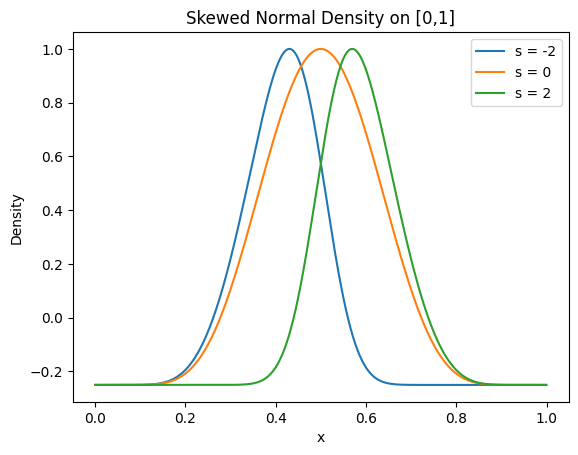

In [24]:
import matplotlib.pyplot as plt
xs = np.linspace(0.001, 0.999, 400)
for s in [-2, 0, 2]:
    plt.plot(xs, normalized_skewed(xs, s, sigma=0.5), label=f's = {s}')
plt.xlabel('x')
plt.ylabel('Density')
plt.title('Skewed Normal Density on [0,1]')
plt.legend()
plt.show()

In [8]:
qubits = cirq.LineQubit.range(3)
X = [sp.Symbol(f'x_{i}') for i in range(3)]
circuit = cirq.Circuit(
    *[cirq.H(qubit) for qubit in qubits],
    *[cirq.Rx(rads=X[i])(qubits[i]) for i in range(len(qubits))]
)

sweeps = [cirq.Linspace(f"x_{i}", 0, 2 * np.pi, 6) for i in range(len(X))]
t_sweep = sweeps.pop()
while len(sweeps) > 0:
    t_sweep = t_sweep * sweeps.pop()

sim = cirq.Simulator()
results = sim.simulate_sweep(circuit, params=t_sweep)

In [9]:
type(results[0].final_state_vector)
compute_bell_curve_proximity(results[0].final_state_vector)

{'bell_mean': 3.5,
 'bell_std': 3.1818181818181817,
 'kl_divergence': 0.3875125660374822,
 'js_divergence': 0.12486920292348619,
 'wasserstein_distance': 0.6656131808351506,
 'bell_curve_alignment_score': 0.720714193497968}

In [81]:
class Gate:
    def __init__(self, gate, qubits, parameter):
        """
        :param gate: enum, [H, Rx, Ry, Rz, CNOT, RZZ]
        :param qubits: tuple (i_0: int,) for gate on qubits i
        :param parameter: p: int U None, parameter to gate given by \theta_p
        :returns None
        """

        self.gates = gate
        self.qubits = qubits
        self.parameter = parameter

    def __str__(self):
        return f"Gate({GATES[self.gates]}, {self.qubits}, {self.parameter})"

    def __copy__(self):
        return Gate(self.gates, self.qubits, self.parameter)

    def __eq__(self, other):
        return id(self) == id(self)

class Gene:
    def __init__(self, gates, n, p: int = None):
        """
        :param gates: Array[Gate] gates in the genome
        :param n: amount of qubits
        :param p: highest number of parameters in the circuit (max param)
        """
        self.gates = gates
        self.n = n

        # find max index parameter in gates
        self.p = max([gate.parameter for gate in gates]) if len(gates) > 0 else 0

    def add_gate(self, g):
        self.gates.append(g)
        self.p = max([gate.parameter for gate in self.gates])

    def to_circuit(self):
        c = cirq.Circuit()
        qubits = cirq.LineQubit.range(self.n)
        X = [sp.Symbol(f'x_{i}') for i in range(self.p + 1)]

        for gate in self.gates:
            qs = [qubits[q] for q in gate.qubits]
            match gate.gates:
                case 0:
                    c.append(cirq.H(*qs))
                case 1:
                    c.append(cirq.Rx(rads=X[gate.parameter])(*qs))
                case 2:
                    c.append(cirq.Ry(rads=X[gate.parameter])(*qs))
                case 3:
                    c.append(cirq.Rz(rads=X[gate.parameter])(*qs))
                case 4:
                    c.append(cirq.CNOT(*qs))
                case 5:
                    c.append(cirq.ZZ(*qs) ** X[gate.parameter])

        c.append(cirq.measure(*qubits, key='x'))

        return c, X

    def evaluate(self, W = [1e1, 1e2, 1e0, 1e2], P=[0.5, 0.5, 0, 0.75, 0, 0.75], o=False) -> int:
        # P:[mean, std, \alpha_0, \sigma_0, \alpha_1, \sigma_1]
        
        circuit, X = self.to_circuit()
        circuit = circuit[:-1]
        
        if len(circuit) == 0:
            return 0.0
        
        sweeps = [cirq.Linspace(f"x_{i}", 0, 2 * np.pi, 6) for i in range(len(X))]
        t_sweep = sweeps.pop()
        while len(sweeps) > 0:
            t_sweep = t_sweep * sweeps.pop()

        sim = cirq.Simulator()
        results = sim.simulate_sweep(circuit, params=t_sweep)
    
        divergence = []
        mw_term = []
        
        for result in results:
            if result.final_state_vector.shape[0] != 2**self.n:
                raise ValueError(f"State vector dimension {result.final_state_vector.shape[0]} does not match 2^{n_qubits}")
            
            divergence.append(compute_bell_curve_proximity(result.final_state_vector, P[0], P[1])['bell_curve_alignment_score'])

            mw_term.append(meyer_wallach_measure(result.final_state_vector))

        divergence = normalized_skewed(sum(divergence) / sum(divergence), P[2], P[3])
        mw_term = normalized_skewed(sum(mw_term) / len(mw_term), P[4], P[5])
            
        all_qubits = set(circuit.all_qubits())  # Get all qubits in the circuit
        used_qubits = set()

        for moment in circuit[:-1]:
            for op in moment.operations:
                used_qubits.update(op.qubits)

        if o: print(f'kl-divergence: {divergence}, mw measure: {mw_term}, depth: {len(circuit)} -> {1 / len(circuit)}, unused qubits: {len(all_qubits - used_qubits)}')

        return  W[0] * divergence + W[1] * mw_term + W[2] * (1 / len(circuit)) - W[3] * (len(all_qubits - used_qubits))

    def mutate(self): # \mu
        def num_g(r, n = 3):
            import math as m

            sigmoid = lambda x: 1 / (1 + m.exp(-x))
            return m.floor((n + 0.5) * sigmoid(2 * m.e * (r - 0.5)))

        # make a copy to be the next version of this agent
        fut = self.__copy__()

        if npr.choice([True, False], p=[MUT_CHANCE, 1-MUT_CHANCE]):
            # select "gene" to mutate
            if npr.choice([True, False], p=[EXPLORE, 1-EXPLORE]):
                for i in range(num_g(rand.random(), self.n // 2) + 1): # add gates based on shifted sigmoid

                    gate = rand.randint(0, 5)
                    open_qubits = list(range(self.n))
                    q1 = open_qubits.pop(npr.choice(open_qubits))
                    q2 = npr.choice(open_qubits) if gate >= 3 else None

                    qubits = (q1, q2) if gate >= 4 else (q1,)

                    # give it a EXPLORE ** 2 to add a new parameter yk
                    parameter = rand.randint(0, fut.p) if npr.choice([False, True], p=[EXPLORE ** 2, 1 - (EXPLORE ** 2)]) else fut.p + 1

                    fut.add_gate(Gate(
                        gate,
                        qubits,
                        parameter
                    ))
            else:
                nchange = num_g(rand.random(), len(self.gates) // 3) # up to third of gates can be changed

                for _ in range(nchange):
                    gate = npr.choice(self.gates)

                    if npr.choice([False, True], p = [EXPLORE, 1-EXPLORE]):
                        gate.gates = rand.randint(0, 3) if gate.gates <= 3 else rand.randint(4, 5)
                        gate.parameter = rand.randint(0, fut.p) if npr.choice([False, True], p=[EXPLORE, 1 - (EXPLORE)]) else fut.p + 1
                    else:
                        self.gates.remove(gate) # womp womp get cooketh

        return fut.__copy__()

    def __str__(self):
        return f'Gene({", ".join([gate.__str__() for gate in self.gates])})'

    def __copy__(self):
        return Gene([g.__copy__() for g in self.gates], self.n, self.p)

## testing out classes

In [58]:
test = Gene([
    Gate(0, (0,), 0),
    Gate(0, (1,), 0),
    Gate(0, (2,), 0)
], 3)
test.evaluate(o=True)

kl-divergence: -0.25, mw measure: -0.25, depth: 1 -> 1.0, unused qubits: 3


-326.5

In [ ]:
test.to_circuit()

In [ ]:
def num_g(r, n = 3, s=2):
    import math as m

    sigmoid = lambda x: 1 / (1 + m.exp(-x))
    return m.floor((n + 0.5) * sigmoid(s * m.e * (r - ((0.25) ** (1/s)))))

# generate a plot for num_g
x = np.linspace(0, 1, 100)
y = [num_g(i, s=4) for i in x]
plt.plot(x, y)
plt.show()

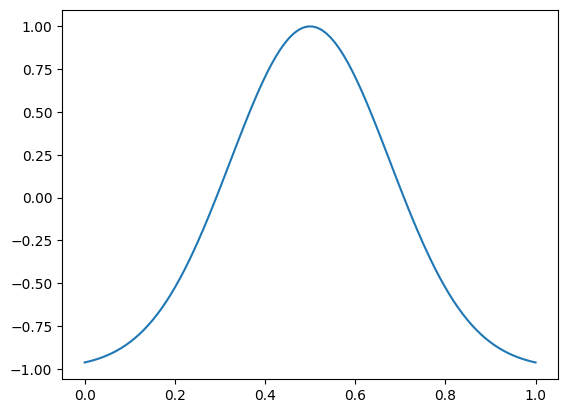

In [3]:
def mw_map(x):
    import math as m
    return 2 * m.exp(-(4 * (x - 0.5))**2) - 1

x = np.linspace(0, 1, 100)
y = [mw_map(i) for i in x]
plt.plot(x, y)
plt.show()

In [ ]:
def depth_map(x):
    import math as m
    return 1.5 * m.exp(-(0.25 * (x - 2.5)) ** 2) - 0.5

x = np.linspace(0, 10, 1000)
y = [depth_map(i) for i in x]
plt.plot(x, y)
plt.show()

In [ ]:
mutated = test.mutate()
while len(mutated.gates) == len(test.gates):
    mutated = test.mutate()

mutated.to_circuit()

In [ ]:
for _ in range(10):
    X = [0.1 * np.pi for _ in range(mutated.p + 1)]
    print(f"fitness: {mutated.evaluate(X)} for {mutated}")
    mutated = mutated.mutate()

In [ ]:
mutated.to_circuit()

oka let's give it a shot

## basic genetic algorithm implementation

In [ ]:
# new hyperparameters
GEN_SIZE = 100
EPOCHS = 15
QUBITS = 4

PERCENTAGE = 0.2 # gen size should be divisible by percentage bc

def num_g(r, n = 3, s=2):
    import math as m

    sigmoid = lambda x: 1 / (1 + m.exp(-x))
    return m.floor((n + 0.5) * sigmoid(s * m.e * (r - ((0.25) ** (1/s)))))

In [ ]:
current_generation = []
for _ in range(GEN_SIZE):
    g = Gene([], QUBITS)

    for _ in range(num_g(rand.random(), QUBITS // 2, s=4)):
        gate = rand.randint(0, 5)
        open_qubits = list(range(QUBITS))
        q1 = open_qubits.pop(npr.choice(open_qubits))
        q2 = npr.choice(open_qubits) if gate >= 4 else None

        qubits = (q1, q2) if gate >= 4 else (q1,)

        # give it a EXPLORE ** 2 to add a new parameter yk
        parameter = rand.randint(0, g.p) if npr.choice([False, True], p=[EXPLORE ** 2, 1 - (EXPLORE ** 2)]) else g.p + 1

        g.add_gate(Gate(
            gate,
            qubits,
            parameter
        ))

    current_generation.append(g)

In [ ]:
for gene in current_generation:
    print(gene) # making sure something doesn't look completely stupid here

In [ ]:
for epoch in range(EPOCHS):
    if epoch % 2 == 0:
        print(f"Epoch {epoch}:")
        print(f"==============")

    total_fitness = []
    for ngene in range(len(current_generation)):
        total_fitness.append(current_generation[ngene].evaluate([0.5 * np.pi for _ in range(current_generation[ngene].p + 1)]))
        if ngene % (GEN_SIZE // 5) == 0 and epoch % 2 == 0:
            print(f'calculated fitness for gene {ngene}.')

    combined_array = zip(current_generation, total_fitness)
    sorted_array = sorted(combined_array, key=lambda x: x[1])

    if epoch % 2 == 0:
        print(f"Max fitness is: ({sorted_array[-1][0]}, {sorted_array[-1][1]})")
        best = sorted_array[-1][0]
        best_performance = sorted_array[-1][1]

    # select PERCENTAGE% of current_generation with highest fitness
    selected = [x[0] for x in sorted_array[int(-PERCENTAGE* GEN_SIZE):]]

    current_generation.clear() # yay

    for gene in selected: # aw :(
        for _ in range(int(GEN_SIZE / (PERCENTAGE * 100))):
            current_generation.append(gene.mutate())

In [ ]:
from cirq.contrib.svg import SVGCircuit, circuit_to_svg

C, params = best.to_circuit()
resolver = cirq.ParamResolver({params[i]: 0.5 * np.pi for i in range(len(params))})

print(best.evaluate([0.5 * np.pi for _ in range(best.p + 1)], o=True))

SVGCircuit(C)

## testing part two

In [82]:
test = Gene([
    Gate(0, (0,), 0),
    *[Gate(4, (0, i+1), 0) for i in range(3)]
], 4)

X = [0.5 * np.pi for _ in range(test.p + 1)]

In [67]:
from cirq.contrib.svg import SVGCircuit, circuit_to_svg

c, params = test.to_circuit()
resolver = cirq.ParamResolver({params[i]: X[i] for i in range(len(X))})

sim = cirq.Simulator()
results = sim.simulate(c[:-1], param_resolver=resolver)

compute_bell_curve_proximity(results.final_state_vector, 0.5, 0.5)

{'bell_mean': 7.499999999999999,
 'bell_std': 6.8181818181818175,
 'kl_divergence': 1.9834582118770636,
 'js_divergence': 0.48324500328904274,
 'wasserstein_distance': 3.825634703257209,
 'bell_curve_alignment_score': 0.33518150045441497}

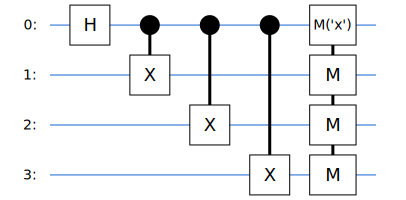

In [84]:
SVGCircuit(c)

In [83]:
test.evaluate(o=True)

kl-divergence: -0.25, mw measure: 0.9999999999998759, depth: 4 -> 0.25, unused qubits: 1


-2.250000000012406

## overall weight particle swarm optimizer

In [6]:
!pip install cirq openfermion openfermionpyscf pyscf matplotlib

import openfermion
from openfermion.transforms import get_fermion_operator, jordan_wigner
from openfermion.linalg import get_sparse_operator
from openfermionpyscf import run_pyscf

from scipy.optimize import minimize, dual_annealing

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [7]:
# hyperparameters
W_bounds = [(1e-1, 1e2), (1e-1, 1e2), (1e-1, 1e2), (1e0, 1e2)]
inertia = 0.85 # weight
phi_p = 1
phi_g = 1

MUT_CHANCE = 0.2
EXPLORE = 0.2 # chance to add new gate

GATES = ["H", "Rx", "Ry", "Rz", "CNOT", "RZZ"]

p_max = 10
particles = [] # [x: [], b: [] vec x, current; vec b, best;

estimation_iters = 5
iters = 15

rounding = 2

In [8]:
# swarm globals
swarm_max = [[], 10000000]
known_v = {}

In [9]:
def compute_energy(gene, parameters, hamiltonian, simulator):
    """Compute the energy expectation value of a state prepared by the ansatz"""
    circuit = cirq.resolve_parameters(gene.to_circuit()[0][:-1], cirq.ParamResolver({
        f'x_{i}': parameters[i] for i in range(len(parameters))
    }))
    
    qs = cirq.LineQubit(4)
    circuit.insert(0, cirq.Circuit())
    
    # For using exact expectation value computation
    energy = 0.0
    
    # Handle the constant term separately
    if () in hamiltonian.terms:
        energy += hamiltonian.terms[()]
    
    # Create a list of all non-constant Pauli terms and their coefficients
    observables = []
    coefficients = []
    
    for term, coefficient in hamiltonian.terms.items():
        if term == ():
            continue  # Already handled the constant term
            
        # Convert the term to a Pauli string observable
        pauli_string = []
        for qubit_idx, pauli_idx in term:
            if pauli_idx == 1:
                pauli_string.append(cirq.X(qubits[qubit_idx]))
            elif pauli_idx == 2:
                pauli_string.append(cirq.Y(qubits[qubit_idx]))
            elif pauli_idx == 3:
                pauli_string.append(cirq.Z(qubits[qubit_idx]))
        
        if pauli_string:
            observables.append(cirq.PauliString(*pauli_string))
            coefficients.append(coefficient)
    
    # Calculate all expectation values at once if there are observables to measure
    if observables:
        expectation_values = cirq.simulate_expectation_values(
            circuit, observables=observables, simulator=simulator
        )
        
        # Sum up the weighted expectation values
        for coef, val in zip(coefficients, expectation_values):
            energy += coef * val
    
    return energy

import numpy as np
from openfermion.chem import MolecularData
from openfermion.transforms import jordan_wigner
from openfermion.linalg import get_sparse_operator
from openfermionpyscf import run_pyscf

# Define molecules
molecules = {
    "LiH": [("Li", (0.0, 0.0, 0.0)), ("H", (0.0, 0.0, 1.6))],
    "BeH2": [("Be", (0.0, 0.0, 0.0)), ("H", (0.0, 0.0, 1.3)), ("H", (0.0, 0.0, -1.3))],
    "H2O": [("O", (0.0, 0.0, 0.0)), ("H", (0.76, 0.58, 0.0)), ("H", (-0.76, 0.58, 0.0))]
}

# Basis set and charge/multiplicity
basis = "sto-3g"
charge = 0
multiplicity = 1

computed_mols = {}

for name, geometry in molecules.items():
    print(f"Calculating for {name}")
    
    # Create molecular data
    molecule = MolecularData(geometry, basis, multiplicity, charge)
    
    # Run PySCF calculation
    molecule = run_pyscf(molecule, run_fci=True)
    
    # Extract FCI energy
    fci_energy = molecule.fci_energy
    print(f"FCI Energy for {name}: {fci_energy:.6f} Ha")
    
    # Get qubit Hamiltonian
    fermionic_hamiltonian = molecule.get_molecular_hamiltonian()
    qubit_hamiltonian = jordan_wigner(fermionic_hamiltonian)
    
    computed_mols[name] = {
        'fci_energy': fci_energy,
        'qubit_hamiltonian': qubit_hamiltonian
    }

Calculating for LiH
FCI Energy for LiH: -7.882324 Ha
Calculating for BeH2
FCI Energy for BeH2: -15.595047 Ha
Calculating for H2O
FCI Energy for H2O: -75.011692 Ha


In [ ]:
from cirq.contrib.svg import SVGCircuit

SVGCircuit(H_C)

In [10]:
def genetic_algorithm(weights, gen_size= 50, epochs=10, qubits=8, percentage=0.1, top_k=3):
    assert top_k < gen_size, "top_k must be less than gen_size"
    
    def num_g(r, n = 3, s=2):
        import math as m

        sigmoid = lambda x: 1 / (1 + m.exp(-x))
        return m.floor((n + 0.5) * sigmoid(s * m.e * (r - ((0.25) ** (1/s)))))

    current_generation = []
    for _ in range(gen_size):
        g = Gene([], qubits)

        for _ in range(num_g(rand.random(), qubits // 2, s=4)):
            gate = rand.randint(0, 5)
            open_qubits = list(range(qubits))
            q1 = open_qubits.pop(npr.choice(open_qubits))
            q2 = npr.choice(open_qubits) if gate >= 4 else None

            qbts = (q1, q2) if gate >= 4 else (q1,)

            # give it a EXPLORE ** 2 to add a new parameter yk
            parameter = rand.randint(0, g.p) if npr.choice([False, True], p=[EXPLORE ** 2, 1 - (EXPLORE ** 2)]) else g.p + 1

            g.add_gate(Gate(
                gate,
                qbts,
                parameter
            ))

        current_generation.append(g)

    for epoch in range(epochs):
        if epoch % (epochs // 2) == 0:
            print(f"Epoch {epoch} for {weights}:")

        total_fitness = []
        for ngene in range(len(current_generation)):
            total_fitness.append(current_generation[ngene].evaluate([0.5 * np.pi for _ in range(current_generation[ngene].p + 1)], W=weights))

        combined_array = zip(current_generation, total_fitness)
        sorted_array = sorted(combined_array, key=lambda x: x[1])

        # select PERCENTAGE% of current_generation with highest fitness
        selected = [x[0] for x in sorted_array[int(-percentage* gen_size):]]
        
        if epoch % (epochs // 2) == 0:
            print(f"Max fitness is: ({sorted_array[-1][0]}, {sorted_array[-1][1]})")
            print("------")

        current_generation.clear() # yay

        for gene in selected: # aw :(
            for _ in range(int(gen_size / (percentage * 100))):
                current_generation.append(gene.mutate())

    return selected[:-(top_k - 1)]

def valuation(weights):

    print("==========")
    
    w = [str(round(weights[i], rounding)) for i in range(len(weights))]
    key = ','.join([f"{'0' * ((3 + rounding) - len(w[i]))}" + w[i] for i in range(len(w))])
    
    if key in known_v:
        print(f"\n[FOUND] Valuation for {weights}: {known_v[key]}, found under {key}\n")
        print("==========")
        
        return known_v[key]
    
    k_genes = genetic_algorithm(weights)
    
    print(len(k_genes))
    
    runs = []
    simulator = cirq.Simulator()

    for gene in k_genes:
        
        def cost_function(parameters, molecule):
            energy = compute_energy(gene, parameters, computed_mols[molecule]['qubit_hamiltonian'], simulator)
            # if isinstance(energy, complex) or (hasattr(energy, "dtype") and np.iscomplex(energy).any()):
            #     return np.real(energy)  # or np.real(result)
            return energy
        
        print(gene)
        
        for _ in range(estimation_iters):
            result = minimize(
                lambda x: cost_function(x, 'LiH'),
                [npr.random() * 2 * np.pi for _ in range(gene.p + 1)]
            )
            
            print(result.fun)

            runs.append(result.fun + result.nfev * 0.25) # take the combined number of iterations to convergence + function value

    known_v[key] = sum(runs) / len(runs)
    
    print(f"\n[CALCULATION] Valuation for {weights}: {known_v[key]}, stored under {key}")
    print("==========")

    return known_v[key]

In [20]:
valuation([1e1, 1e2, 1e2, 1e2])
known_v = {}

Epoch 0 for [10.0, 100.0, 100.0, 100.0]:
Max fitness is: (Gene(Gate(Ry, (4,), 0), Gate(CNOT, (2, 6), 0), Gate(H, (2,), 0), Gate(Ry, (3,), 0)), -328.272245011303)
------
Epoch 5 for [10.0, 100.0, 100.0, 100.0]:
Max fitness is: (Gene(Gate(Ry, (4,), 0), Gate(CNOT, (2, 6), 0), Gate(H, (2,), 0), Gate(Ry, (3,), 0), Gate(H, (1,), 0), Gate(RZZ, (6, 3), 0), Gate(Rx, (0,), 0), Gate(Rx, (7,), 0)), -28.220413938393335)
------
3
Gene(Gate(Ry, (4,), 0), Gate(CNOT, (2, 6), 0), Gate(H, (2,), 0), Gate(Ry, (3,), 0), Gate(H, (1,), 0), Gate(RZZ, (6, 3), 0), Gate(Rx, (0,), 0), Gate(Rx, (7,), 0), Gate(H, (4,), 0), Gate(H, (2,), 0), Gate(RZZ, (3, 0), 0), Gate(Ry, (6,), 1), Gate(Ry, (4,), 1))
-4.135867179465939
-4.135867179465939
-4.135867179465939
-4.135867179465939
-4.135867179465939
Gene(Gate(CNOT, (2, 6), 0), Gate(H, (2,), 0), Gate(Ry, (3,), 0), Gate(H, (1,), 0), Gate(RZZ, (6, 3), 0), Gate(Rx, (0,), 0), Gate(Rx, (7,), 0), Gate(Rx, (4,), 2), Gate(H, (2,), 0), Gate(CNOT, (3, 0), 1), Gate(H, (6,), 1))
-4.135

In [ ]:
import numpy as np

W_1 = np.random.uniform(W_bounds[0][0], W_bounds[0][1], p_max)
W_2 = np.random.uniform(W_bounds[1][0], W_bounds[1][1], p_max)
W_3 = np.random.uniform(W_bounds[2][0], W_bounds[2][1], p_max)
W_4 = np.random.uniform(W_bounds[3][0], W_bounds[3][1], p_max)

def random_velocity():
    r = []
    
    for i in range(4):
        r.append(rand.uniform(-1 * abs(W_bounds[i][1] - W_bounds[i][0]), abs(W_bounds[i][1] - W_bounds[i][0]) ))
    
    return r

# for p \in P, p = [x, v, [ b, f(b) ] ]

particles = [ [ [W_1[i], W_2[i], W_3[i], W_4[i]], random_velocity(), [ [W_1[i], W_2[i], W_3[i], W_4[i]] , 0] ] for i in range(p_max)] # best is same as current position

for i in range(len(particles)):
    fitness = valuation(particles[i][0])
    if fitness < swarm_max[1]:
        swarm_max[0] = particles[i][0]
        swarm_max[1] = fitness

    particles[i][2][1] = fitness # initialize best fitness result
    print("")

In [ ]:
T = 0

while T < iters:
    for i in range(len(particles)):
        for d in range(len(particles[i][0])):
            r_p, r_g = (rand.random(), rand.random())
            particles[i][1][d] = inertia * particles[i][1][d] + phi_p * r_p * (particles[i][2][0][d] - particles[i][0][d]) + phi_g * r_g * (swarm_max[0][d] - particles[i][0][d])
            
        for d in range(len(particles[i][0])):
            particles[i][0][d] += particles[i][1][d]
        
        fitness = valuation(particles[i][0])
        
        if fitness < particles[i][2][1]:
            particles[i][2][0] = particles[i][0]
            particles[i][2][1] = fitness
            
            if fitness < swarm_max[1]:
                swarm_max[0] = particles[i][0]
                swarm_max[1] = fitness
                print(f"NEW SWARM MAX: {fitness} @ {particles[i][0]}")